# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [ ]:
!pip install pytorch-transformers
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 11.4 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=6438f5b2dc2ec69723977d5bfc9eb93cdaae24a6c70c3e76b6a72e9a21654f56
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords") 
stop = set(stopwords.words('english'))
stop
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import wordnet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import time
from sklearn.feature_extraction.text import CountVectorizer 
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
import re 
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.



# Подготовка

In [ ]:
try:
    toxic = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    toxic = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

In [ ]:
display(toxic.info())
display(toxic.head())
display(toxic.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


text     0
toxic    0
dtype: int64

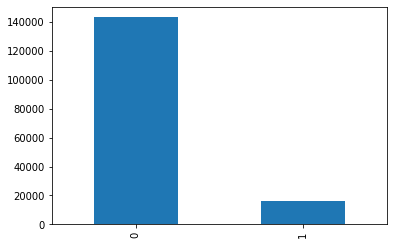

In [ ]:
toxic['toxic'].value_counts().plot(kind='bar')

* дубликатов и пропусков нет
* 90% твитов не токсичны
* классы несблансированы
* нужно сделать леммизацию и токенизацию комментариев
* привести текст к одному регистру 
*  upsampled увеличить выборку с положительным классом 
*  downsampled уменьшить выборку с отрицательным




### Создадим корпус слов

In [ ]:
corpus = toxic['text'].values

### Леммизация и токенизация

In [ ]:
corpus = list(toxic['text'])

In [ ]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())

In [ ]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
test = 'I want that this wonderful project will be accept'
print([WordNetLemmatizer().lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(test)])

['I', 'want', 'that', 'this', 'wonderful', 'project', 'will', 'be', 'accept']


In [ ]:
def lemmafunction(textc):
    k = []
    for i in nltk.word_tokenize(textc):
        k.append(WordNetLemmatizer().lemmatize(i, get_wordnet_pos(i)))
    return ' '.join(k) 

lemy=[]
for i in tqdm(range(len(corpus))):
    lemy.append(lemmafunction(clear_text(corpus[i])))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
toxic['lemm_text'] = pd.Series(lemy, index=toxic.index)

In [ ]:
toxic

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,And for the second time of ask when your view ...
159447,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That be a ho...
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm there no actual article for prosti...
159449,And it looks like it was actually you who put ...,0,And it look like it be actually you who put on...


# Обучение 


## Разделим данные

In [ ]:
X = toxic.drop('toxic', axis=1)
y = toxic['toxic']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True,stratify=y)
print('тренировочная выборка- {:.0%}'.format(X_train.shape[0]/X.shape[0]))
print('тестовая выборка - {:.0%}'.format(X_test.shape[0]/X.shape[0]))

тренировочная выборка- 70%
тестовая выборка - 30%


### Создадим функцию, для увеличения выборки по 1 классу данных и уменьшению выборки по нулевому [0]0

In [ ]:
def down_up_sample(features, target, fraction, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_down_up = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]*repeat)
    target_down_up = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]*repeat)
    
    features_down_up_sampled, target_down_up_sampled = shuffle(
        features_down_up, target_down_up, random_state=12345)
    
    return features_down_up_sampled, target_down_up_sampled

features_upsampled, target_upsampled  = down_up_sample(X_train, y_train, 0.6, 5)

0    60104
1    56650
Name: toxic, dtype: int64


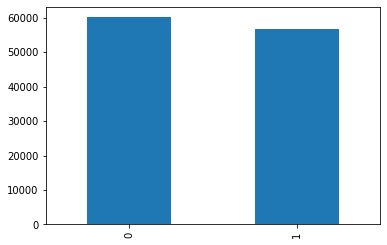

In [ ]:
print(target_upsampled.value_counts())
display(target_upsampled.value_counts().plot(kind='bar'))


### TF-IDF для обработки данныx

In [ ]:
nltk.download('stopwords') 
stop_words = set(nltk_stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
corpus_lemm_train = features_upsampled['lemm_text'].values
corpus_lemm_test = X_test['lemm_text'].values

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words,analyzer='word') 
tf_idf = count_tf_idf.fit_transform(corpus_lemm_train) 
tf_test = count_tf_idf.transform(corpus_lemm_test)

### DecisionTreeClassifier

In [ ]:
%%time
gs_params = {
    'max_depth': range(1, 11),
    'min_samples_leaf':range(1,11)}

gs_tree = RandomizedSearchCV(DecisionTreeClassifier(random_state=12345),gs_params,scoring='f1',cv=5, n_iter=20)
gs_tree.fit(tf_idf,target_upsampled)


print(gs_tree.best_estimator_)
print(gs_tree.best_score_)
print(gs_tree.best_params_)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=10, random_state=12345)
0.5905621718387974
{'min_samples_leaf': 10, 'max_depth': 9}
CPU times: user 14min, sys: 755 ms, total: 14min 1s
Wall time: 14min 1s


### LogisticRegression

In [ ]:
%%time
gs_params = {
    'solver': ['liblinear', 'sag','saga','newton-cg'],
    'C': [0.5,1.0,1.5],
    'intercept_scaling':[0.5,1.0,1.5]}
gs_logistic = RandomizedSearchCV(LogisticRegression(random_state=12345),gs_params,scoring='f1', cv=5, n_iter=20)
gs_logistic.fit(tf_idf,target_upsampled)

print(gs_logistic.best_estimator_)
print(gs_logistic.best_score_)
print(gs_logistic.best_params_)

LogisticRegression(C=1.5, intercept_scaling=1.5, random_state=12345,
                   solver='saga')
0.9518866077940664
{'solver': 'saga', 'intercept_scaling': 1.5, 'C': 1.5}
CPU times: user 3min 35s, sys: 1min 35s, total: 5min 10s
Wall time: 3min 25s



### RandomForestClassifier

In [ ]:
%%time

rs_params = {
    'max_depth': range(1, 30),
    'min_samples_leaf':range(1,11)}

tree_balanced_rs = RandomizedSearchCV(RandomForestClassifier(random_state=12345),rs_params,scoring='f1',cv=5, n_iter=20)
tree_balanced_rs.fit(tf_idf,target_upsampled)


CPU times: user 43min 19s, sys: 2.98 s, total: 43min 22s
Wall time: 43min 33s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
                   n_iter=20,
                   param_distributions={'max_depth': range(1, 26),
                                        'min_samples_leaf': range(1, 11)},
                   scoring='f1')

In [ ]:
print(tree_balanced_rs.best_estimator_)
print(tree_balanced_rs.best_score_)
print(tree_balanced_rs.best_params_)

RandomForestClassifier(max_depth=24, min_samples_leaf=3, random_state=12345)
 
0.838884928933264
 
{'min_samples_leaf': 3, 'max_depth': 24}


# Тестирование модели 

In [ ]:
%%time
gs_params = {
    'solver': ['liblinear', 'sag','saga','newton-cg'],
    'C': [0.5,1.0,1.5],
    'intercept_scaling':[0.5,1.0,1.5]
}
gs_logistic = RandomizedSearchCV(LogisticRegression(random_state=12345),gs_params,scoring='f1', cv=5, n_iter=20)
gs_logistic.fit(tf_idf,target_upsampled)
predicted_lr = gs_logistic.predict(tf_test)
f1_log_r_1 = f1_score(y_test, predicted_lr)
print(f1_log_r_1)

0.7408350768670973
CPU times: user 4min 11s, sys: 2min 23s, total: 6min 34s
Wall time: 3min 58s


In [ ]:
probabilities=gs_logistic.predict_proba(tf_test)
probabilities_one = probabilities[:, 1]
print("Вероятность положительного класса:",probabilities_one[:5])

Вероятность положительного класса: [0.05779784 0.02854877 0.00848526 0.9512111  0.16074299]


In [ ]:
for threshold in np.arange(0.4, 0.9, 0.02):
    predicted_v = probabilities_one > threshold
    f1 = f1_score(y_test,predicted_v)
    print("F1 = {:.3f}".format(threshold, f1))

F1 = 0.400
F1 = 0.420
F1 = 0.440
F1 = 0.460
F1 = 0.480
F1 = 0.500
F1 = 0.520
F1 = 0.540
F1 = 0.560
F1 = 0.580
F1 = 0.600
F1 = 0.620
F1 = 0.640
F1 = 0.660
F1 = 0.680
F1 = 0.700
F1 = 0.720
F1 = 0.740
F1 = 0.760
F1 = 0.780
F1 = 0.800
F1 = 0.820
F1 = 0.840
F1 = 0.860
F1 = 0.880


In [ ]:
predicted_rf_threshold=(probabilities_one>0.76)*1
print(classification_report(y_test,predicted_rf_threshold))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     42932
           1       0.84      0.71      0.77      4856

    accuracy                           0.96     47788
   macro avg       0.90      0.85      0.87     47788
weighted avg       0.95      0.96      0.95     47788



In [ ]:
predicted_test=(gs_logistic.predict_proba(tf_test)[:,1] > 0.76)*1
f1_log_r_1 = f1_score(y_test, predicted_test)
print('F1: ',f1_log_r_1)

F1:  0.7674626199509039


LogisticRegression показала наилучший результат при обучении, это подтверждает значение метрики $F1 > 0.75$ 



# Вывод

* дубликатов и пропусков нет
* 90% твитов не токсичны
* сделана леммизация и токенизация комментариев
* классы были изначально несбалансированны, с помощью `upsample` и `downsamle` удалось это изменить, так как дисбаланс влияет на качество предсказанных моделей
* текст приведен к одному регистру 
* Обучено три модели DecisionTreeClassifier ,  LogisticRegression и RandomForestClassifier
* По результатам было выявлено:  f1  в LogisticRegression = 0.767